In [421]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split,GridSearchCV 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

#import string

In [422]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [423]:
# check the DF for NA values
print(df.shape)
df.isna().sum().sort_values(ascending=False)

(11162, 17)


balance      25
age           0
day           0
poutcome      0
previous      0
pdays         0
campaign      0
duration      0
month         0
contact       0
job           0
loan          0
housing       0
default       0
education     0
marital       0
deposit       0
dtype: int64

In [424]:
df.iloc[2000:2010]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
2000,26,services,married,secondary,no,"77,00 $",yes,no,cellular,15,may,619,1,340,4,failure,yes
2001,35,blue-collar,married,primary,no,"22,00 $",yes,no,cellular,15,may,1190,2,302,2,other,yes
2002,22,blue-collar,single,secondary,no,"-51,00 $",yes,no,cellular,15,may,859,1,-1,0,unknown,yes
2003,26,blue-collar,single,secondary,no,"26,00 $",yes,yes,cellular,15,may,899,1,-1,0,unknown,yes
2004,28,admin.,single,secondary,no,"154,00 $",yes,no,cellular,15,may,536,1,364,1,other,yes
2005,35,admin.,divorced,secondary,no,"534,00 $",no,no,cellular,15,may,669,1,312,3,failure,yes
2006,35,housemaid,married,tertiary,no,"1 265,00 $",yes,no,cellular,15,may,326,5,179,4,failure,yes
2007,55,technician,married,tertiary,no,"-466,00 $",yes,no,cellular,15,may,901,1,-1,0,unknown,yes
2008,32,services,married,secondary,no,"38,00 $",yes,no,cellular,15,may,744,1,-1,0,unknown,yes
2009,28,management,single,secondary,no,"703,00 $",yes,no,cellular,15,may,485,1,88,1,other,yes


In [425]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [426]:
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

    There are NA values in 'balance' and 'unknown' in 'job' & 'education'

In [427]:
# remove NA and 'unknown'
df['balance'] = df['balance'].apply(lambda x: str(x).replace(' ','').replace('$', '').replace(',', '.')).astype(np.float64)
df['balance'] = df['balance'].fillna(df['balance'].median())

df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown' else x)
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x == 'unknown' else x)

,deposit,count
0,no,5873
1,yes,5289


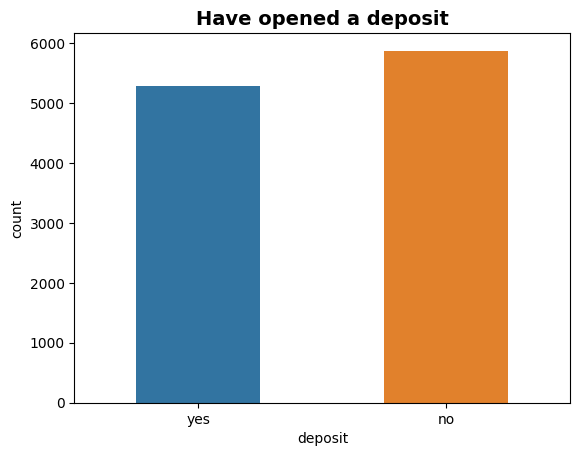

In [428]:
# target's classes balance
display(df['deposit'].value_counts(normalize=False).reset_index().round(2))

cp = sns.countplot(df, x='deposit', width=0.5);
cp.set_title('Have opened a deposit', fontsize=14, fontweight='bold');

## EDA

In [429]:
num_fea = df.dtypes[df.dtypes != 'object'].index.tolist()
cat_fea = df.dtypes[df.dtypes == 'object'].index.tolist()

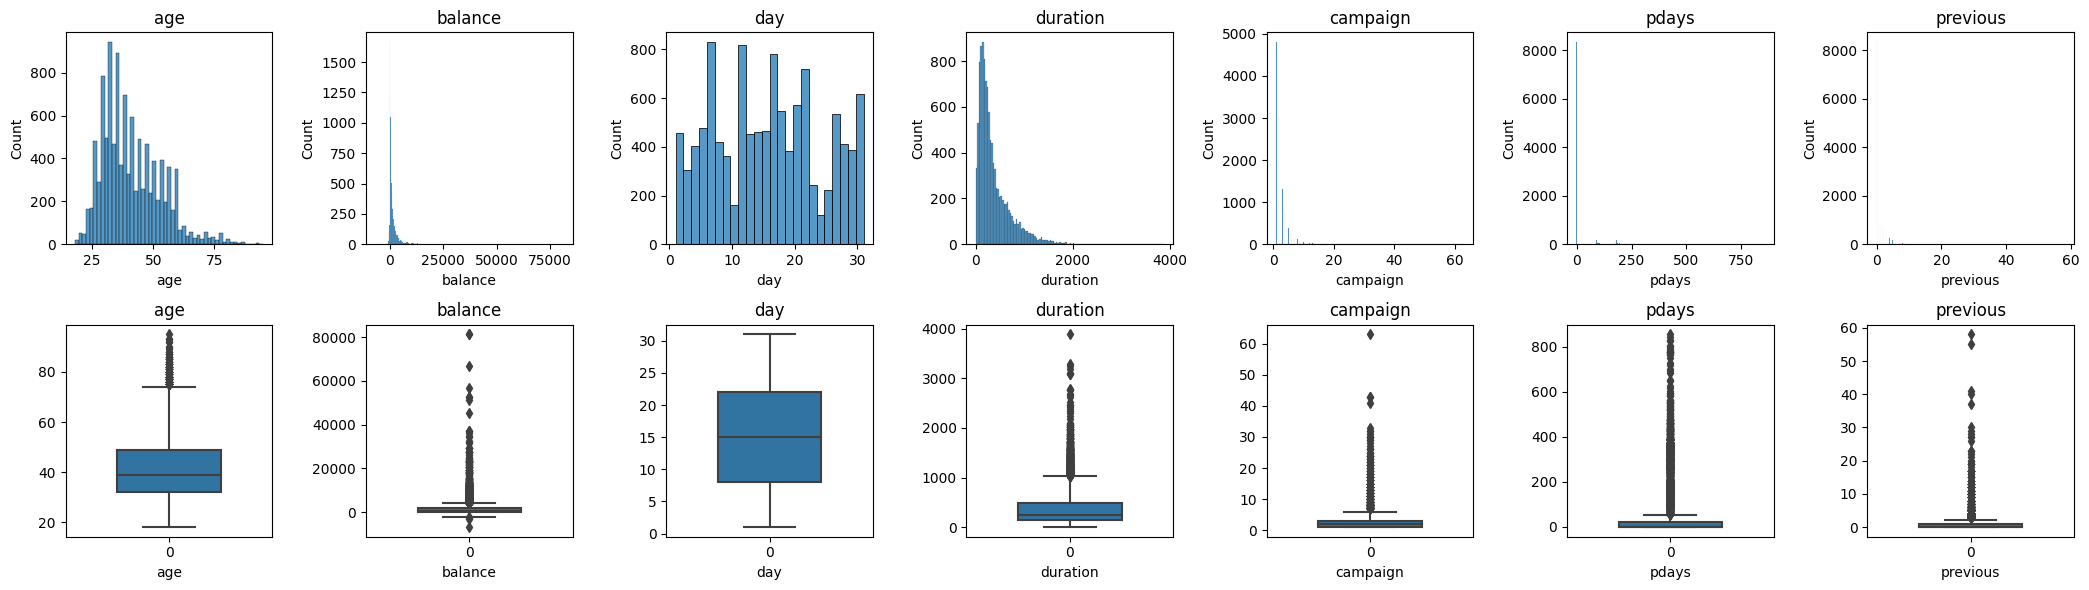

In [430]:
# let's assess numeric feature distributions
f,a=plt.subplots(2,len(num_fea), figsize=(len(num_fea)*3,6))
for k,m in enumerate(num_fea):
    sns.histplot(data=df[m], ax=a[0][k]).set(title=m, xlabel=m)
    sns.boxplot(data=df[m], orient='v', ax=a[1][k], width=0.5).set(title=m, xlabel=m)
plt.tight_layout()

In [431]:
# remove outliers from 'balance'
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    """The function is designed to define outliers in a data set according to 
    the Tjuki method

    Args:
        data (dataframe): source DF
        feature (str): feature to evaluate
        left (float, optional): left limit. Defaults to 1.5.
        right (float, optional): right limit. Defaults to 1.5.
        log_scale (bool, optional): if data should be treated logarithmically. 
            Defaults to False.

    Returns:
        df,df,float,float: outliers, cleaned, lower_bound, upper_bound
    """
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, low, high = outliers_iqr_mod(df, 'balance', log_scale=False)
print(f'"Balance" outliers found according to the Tjuki method: {outliers.shape[0]}')
dfc = cleaned
print(f'DF shape with outliers removed: {dfc.shape}')
print(f"low bound: {round(low,0)} | high bound: {round(high,0)}")

"Balance" outliers found according to the Tjuki method: 1057
DF shape with outliers removed: (10105, 17)
low bound: -2241.0 | high bound: 4063.0


In [432]:
dfc.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


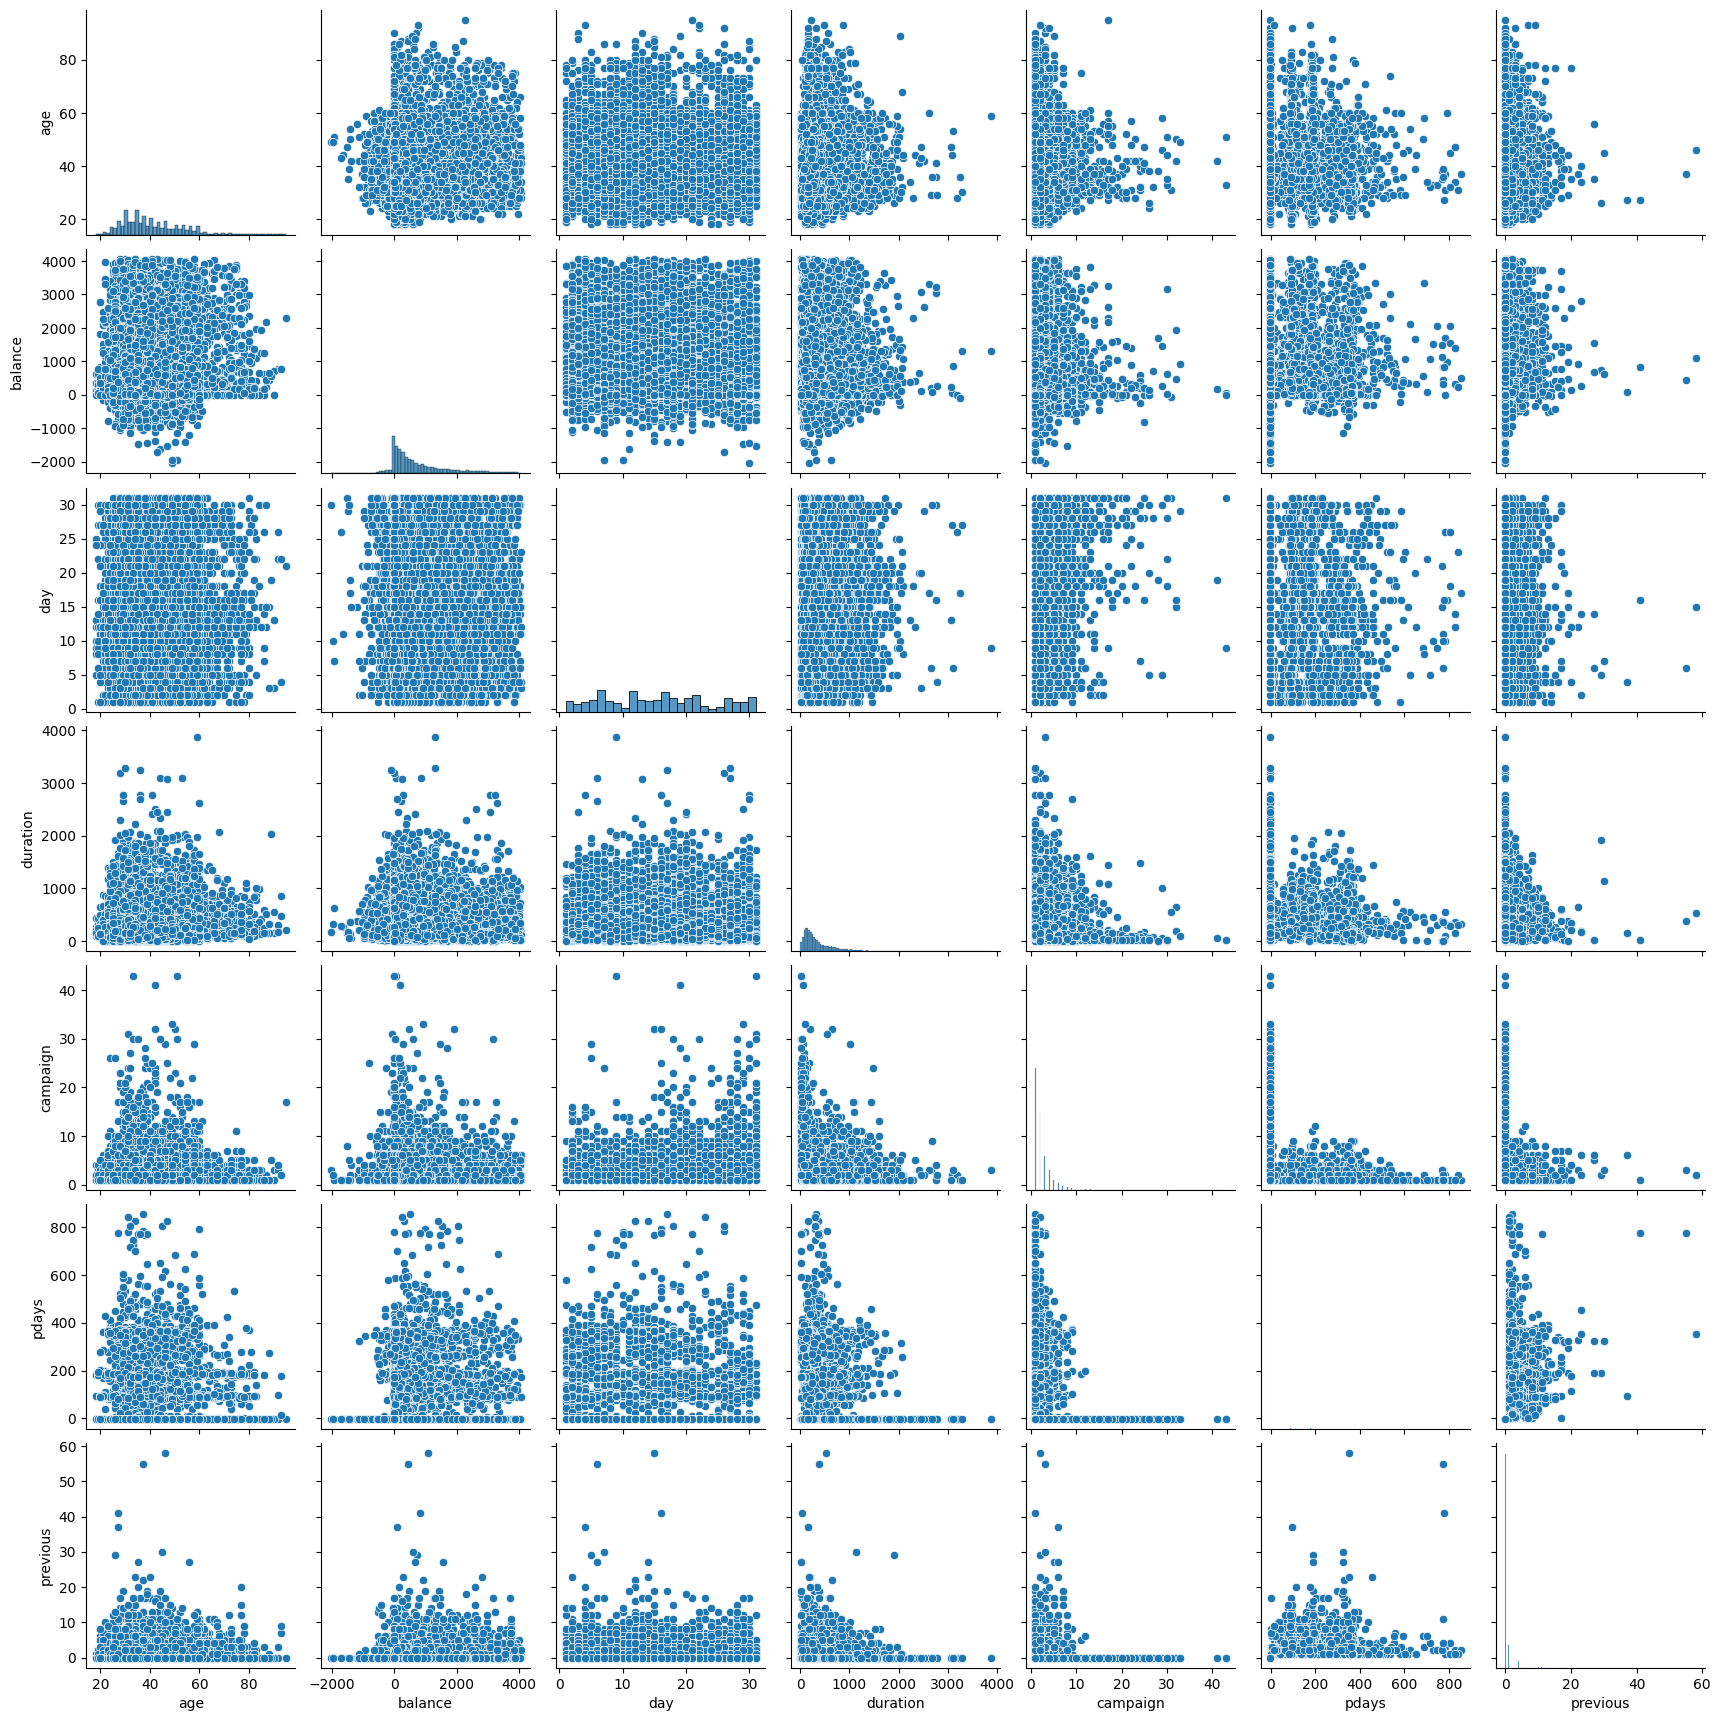

In [433]:
sns.pairplot(dfc[num_fea]);

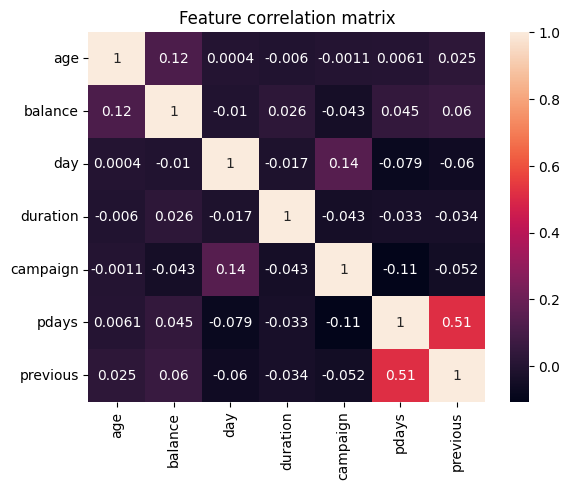

In [434]:
sns.heatmap(dfc.corr(numeric_only=True), annot=True).set_title('Feature correlation matrix');

    there is no critical correlation between the features

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


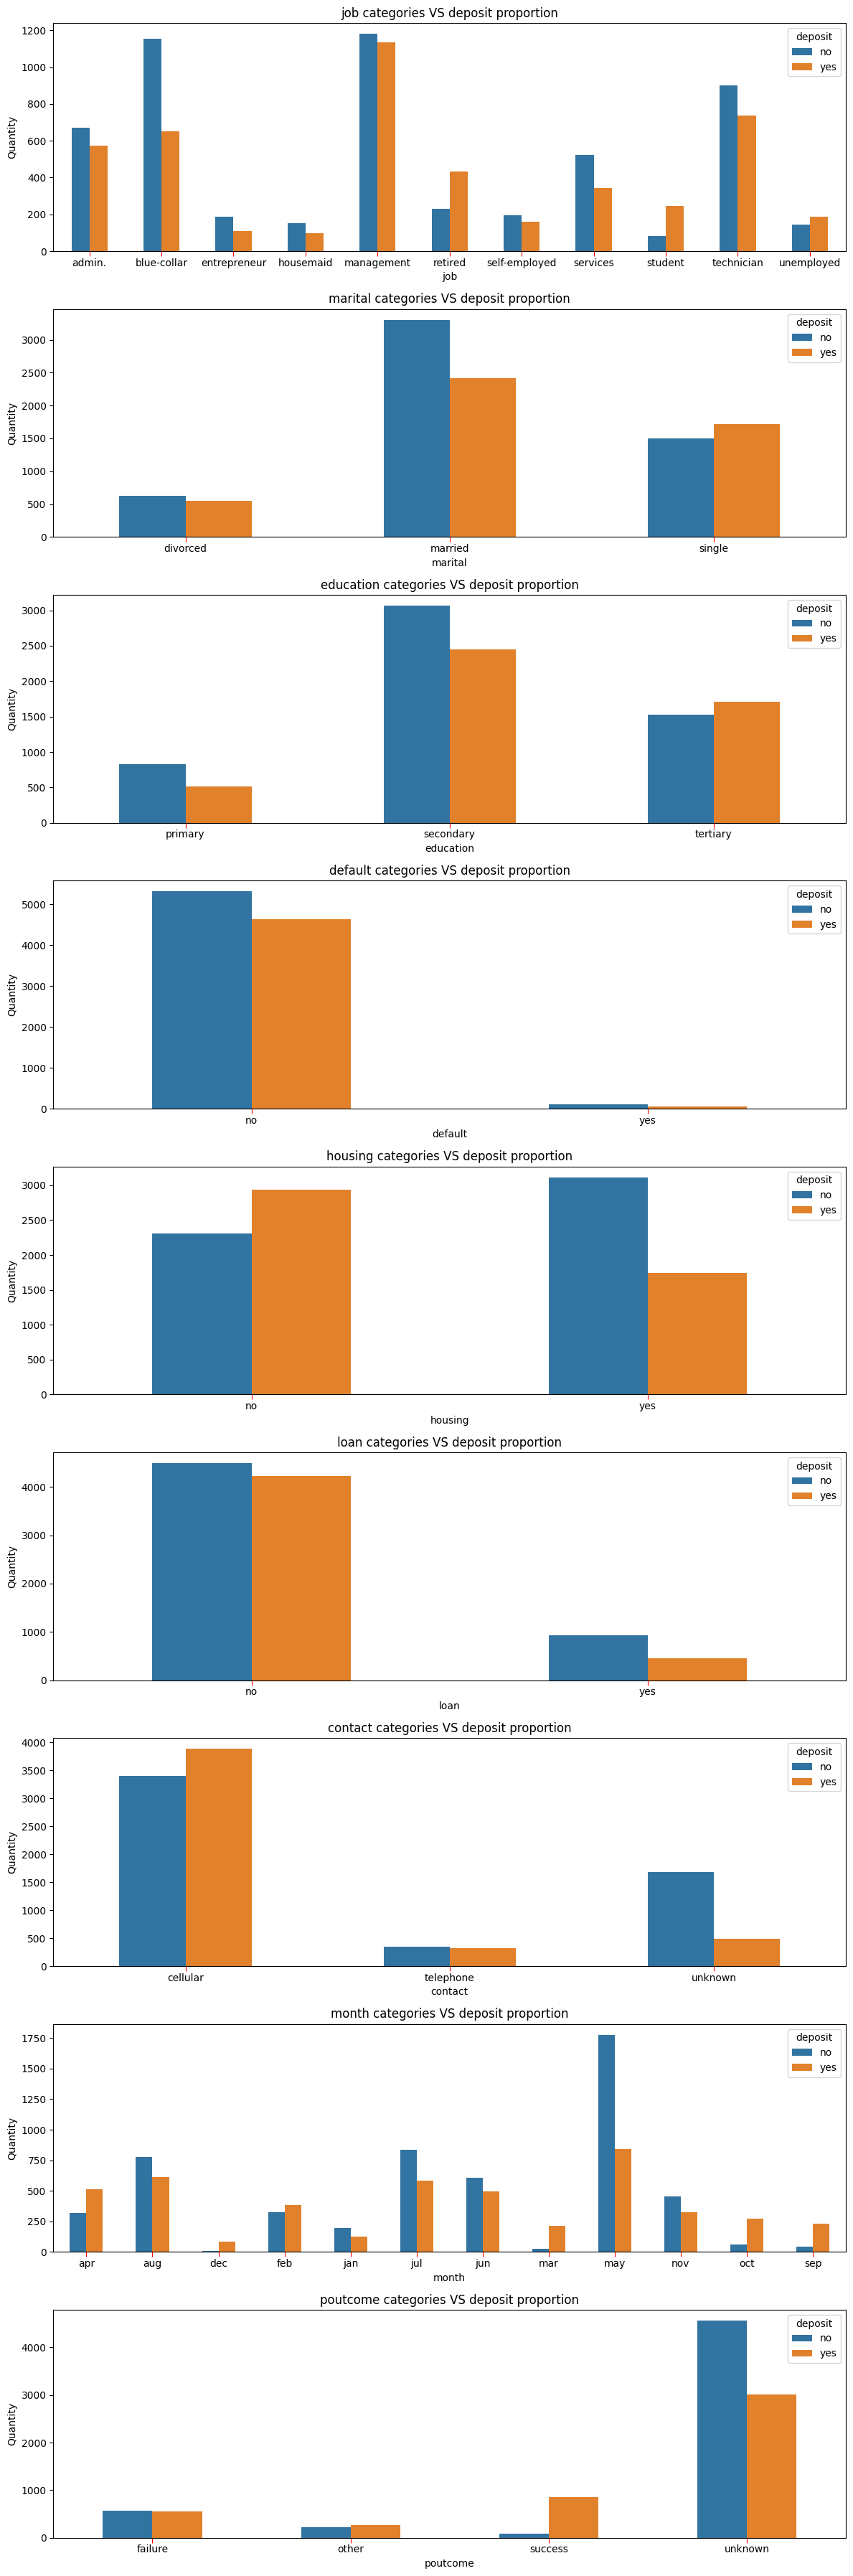

In [435]:
# let's investigate cathegorial features
display(dfc[cat_fea].describe())

cat_fea.remove('deposit')

f,a = plt.subplots(nrows=len(cat_fea), ncols=1, figsize=(12,36))
for k, m in enumerate(cat_fea):
    dfg = dfc.groupby([m, 'deposit'])['deposit'].count().rename('qty').reset_index()
    bp = sns.barplot(dfg, x=m, y='qty', hue='deposit', ax=a[k], width=0.5)
    bp.set(xlabel=m, ylabel='Quantity', title=f"{m} categories VS deposit proportion")
    bp.tick_params(axis='x',rotation=0, direction='out', pad=2, length=5, grid_alpha=0.3, which='both', color='red')
plt.tight_layout()

In [436]:
# the results of the previous campaign (poutcome)
dc = dfc.groupby(['poutcome', 'deposit'])['deposit'].count().unstack()
dc

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


,month,deposit,proportion
16,may,no,0.678640
8,jan,no,0.608150
10,jul,no,0.589563
18,nov,no,0.584615
2,aug,no,0.559567
12,jun,no,0.548913
7,feb,no,0.455571
1,apr,no,0.381928
21,oct,no,0.185075
23,sep,no,0.165468


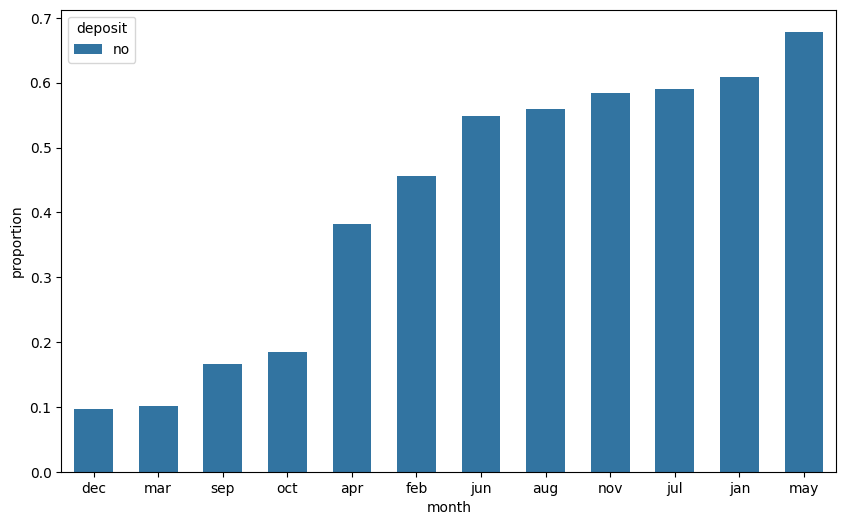

In [437]:
# let's define which month was the most popular with "no deposit" decision
df_7 = dfc.groupby(['month'])['deposit'].value_counts(normalize=True).reset_index().sort_values(by=('proportion'))
plt.subplots(figsize=(10,6))
bp_7 = sns.barplot(df_7[df_7['deposit']=='no'], x='month', y='proportion', hue='deposit', width=0.6)
df_7[df_7['deposit']=='no'].sort_values(by='proportion', ascending=False)


,age_group,deposit,proportion
0,30-40,no,0.576523
1,30-40,yes,0.423477
2,40-50,no,0.603104
3,40-50,yes,0.396896
4,50-60,no,0.574154
5,50-60,yes,0.425846
6,<30,yes,0.562032
7,<30,no,0.437968
8,>60,yes,0.810916
9,>60,no,0.189084


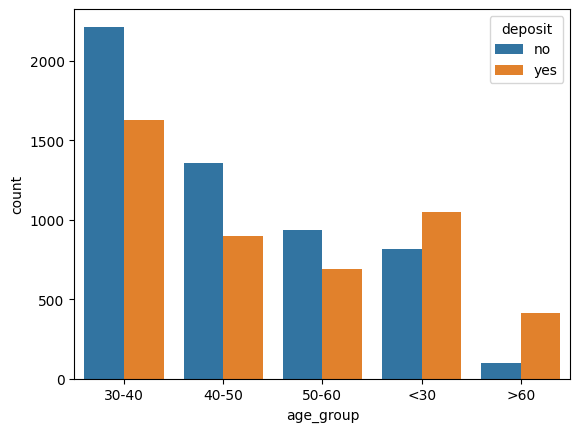

In [438]:
# devide customers according to the age group
#df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])

def group_age(num):
    if num <=30:
        return '<30'
    elif num>30 and num<=40:
        return '30-40'
    elif num>40 and num<=50:
        return '40-50'
    elif num>50 and num<=60:
        return '50-60'
    else:
        return '>60'
    
dfc['age_group'] = dfc['age'].apply(group_age)
display(dfc.groupby('age_group')['deposit'].value_counts(normalize=True).reset_index())

sns.countplot(dfc.sort_values(by='age_group'), x='age_group', hue='deposit').set_title('');

    there are 2 groups where the quantity of opened deposits dominates: <30, >60

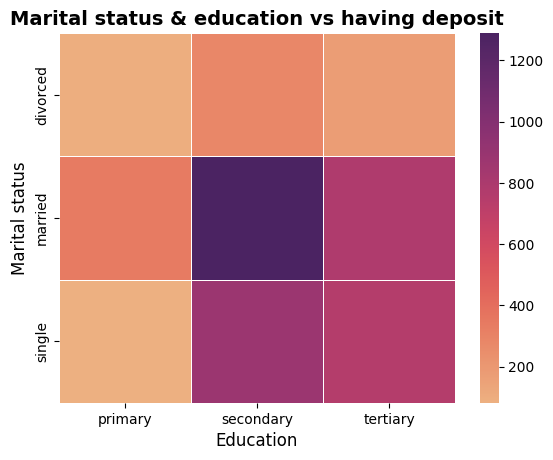

In [439]:
# let's define which combination of marital & education represents the majority
pivot = pd.pivot_table(
    dfc[dfc['deposit']=='yes'],
    values= 'deposit',
    index= 'marital',
    columns='education',
    aggfunc='count'    
)

hm = sns.heatmap(pivot,annot=False, linewidths=.5, cmap='flare')
hm.set_title('Marital status & education vs having deposit', fontsize=14, fontweight='bold')
hm.set_ylabel('Marital status', fontsize=12)
hm.set_xlabel('Education', fontsize=12);

## Feature selection & preprocessing

In [440]:
#ct = ColumnTransformer(transformers=[
#    ('label_enc', OrdinalEncoder(), ['education','age_group'])
#], remainder='passthrough')

# encoding cathegorial features
oe = OrdinalEncoder()
dfc.loc[:, ['education', 'age_group']] = oe.fit_transform(dfc.loc[:, ['education', 'age_group']])
dfc['education'] = dfc['education'].astype(np.int32)
dfc['age_group'] = dfc['age_group'].astype(np.int32)
dfc['education'].sum()

11995

In [441]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  int32  
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
 17  age_group  10105 non-null  int32  
dtypes: float64(1), int32(2), int64(6), object(9)
memory usage: 1.4+ MB


In [442]:
# transform features to the binary format
l = ['deposit', 'default', 'housing', 'loan']

for k in l:
    dfc[k] = dfc[k].apply(lambda x: 1 if x=='yes' else 0)


In [443]:
# transform features to dummies
dfc = pd.get_dummies(dfc, columns=['job', 'marital', 'contact', 'month', 'poutcome']) #drop_first=True,

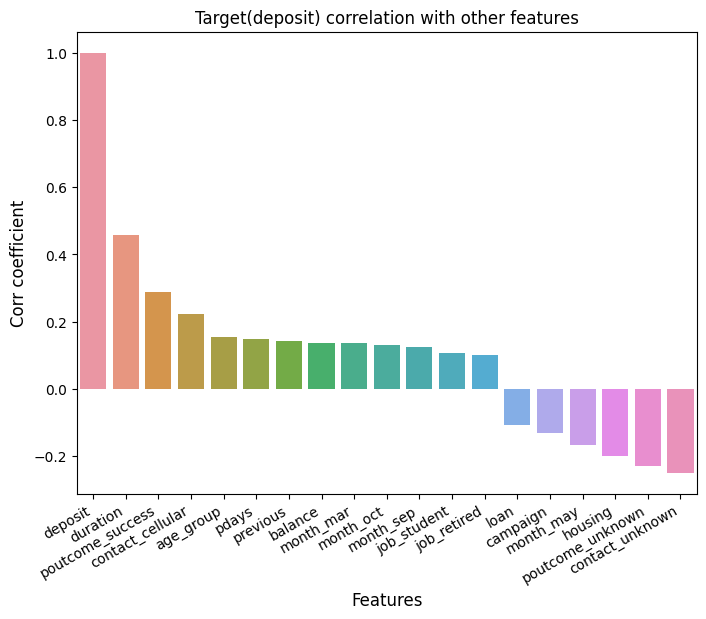

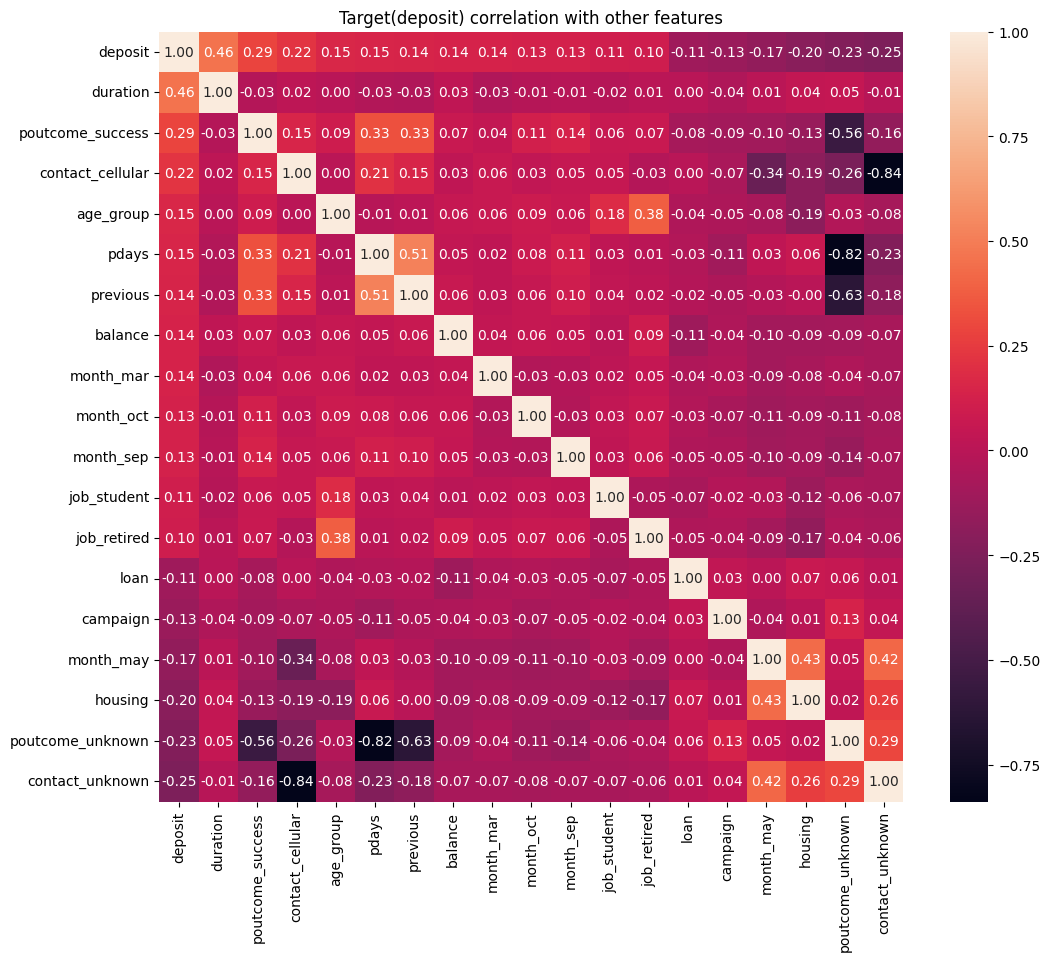

In [444]:
# investigate correlation between features
df_corr = dfc.corr()['deposit'].sort_values(ascending=False).reset_index()

plt.subplots(figsize=(8,6))
bp_corr = sns.barplot(df_corr[abs(df_corr['deposit'])>0.1], x='index', y='deposit');
bp_corr.set_title('Target(deposit) correlation with other features')
bp_corr.set_ylabel('Corr coefficient', fontsize=12)
bp_corr.set_xlabel('Features', fontsize=12);
#bp_corr.tick_params(axis='x', rotation=50)
plt.xticks(rotation=30, ha='right');
#sns.heatmap(dfc.corr(numeric_only=True), annot=True)

corr_fea = df_corr[abs(df_corr['deposit'])>0.1]['index'].tolist()
plt.subplots(figsize=(12,10))
sns.heatmap(dfc[corr_fea].corr(), annot=True, fmt='.2f').set_title('Target(deposit) correlation with other features');

In [445]:
# separate the target
X = dfc.drop(['deposit'], axis=1)
y = dfc['deposit']

# devide data to training and validation subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

print(f"TRAIN {X_train.shape}")
print(f"TEST  {X_test.shape}")

TRAIN (6770, 45)
TEST  (3335, 45)


In [446]:
# scale data
#scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.RobustScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model selection for the classification task

### LogisticRegression

In [447]:
# let's fit LR and assess metrics
log_reg = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)
#print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1790
           1       0.81      0.76      0.79      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.81      0.81      3335



### DecisionTree

In [448]:
dt = tree.DecisionTreeClassifier(
    #criterion='gini', 
    criterion='entropy',
    random_state=42, #генератор случайных чисел
    #max_depth=6
)

dt.fit(X_train_scaled, y_train)

y_pred_train = dt.predict(X_train_scaled)
y_pred_test = dt.predict(X_test_scaled)

print(f"TRAIN {metrics.classification_report(y_train, y_pred_train)}")
print(f"TEST {metrics.classification_report(y_test, y_pred_test)}")

TRAIN               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

TEST               precision    recall  f1-score   support

           0       0.80      0.81      0.80      1790
           1       0.77      0.76      0.77      1545

    accuracy                           0.79      3335
   macro avg       0.79      0.78      0.78      3335
weighted avg       0.79      0.79      0.79      3335



    the model is  overfitted. let's handle it

Max TEST accuracy 0.81 with max_depth 12
Max TEST f1       0.8 with max_depth 9


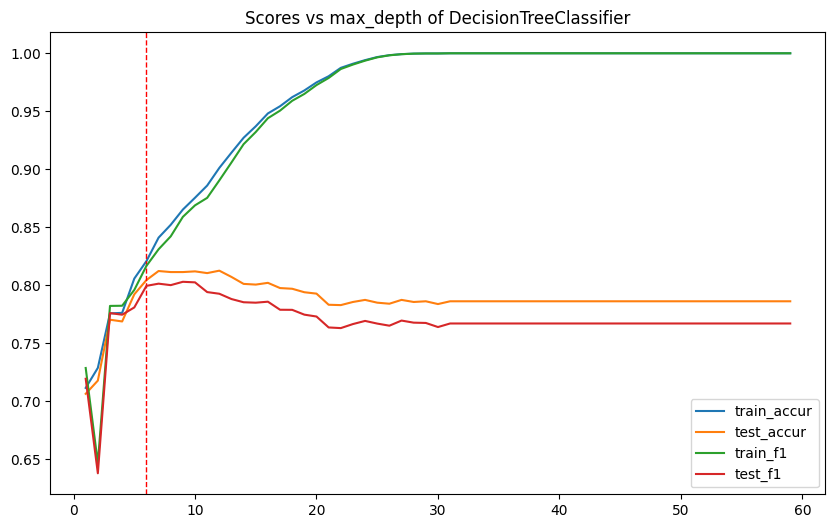

In [449]:
# visualize max_depth influence to the metrics on train and test subsets
train = {'accuracy':[], 'f1':[]}
test = {'accuracy':[], 'f1':[]}
depths = np.arange(1,60,1)

for k in depths:
    dt = tree.DecisionTreeClassifier(
    #criterion='gini', 
    criterion='entropy',
    random_state=42, #генератор случайных чисел
    max_depth=k)

    dt.fit(X_train_scaled, y_train)

    y_pred_train = dt.predict(X_train_scaled)
    y_pred_test = dt.predict(X_test_scaled)

    train['accuracy'].append(metrics.accuracy_score(y_train, y_pred_train))
    train['f1'].append(metrics.f1_score(y_train, y_pred_train))
    test['accuracy'].append(metrics.accuracy_score(y_test, y_pred_test))
    test['f1'].append(metrics.f1_score(y_test, y_pred_test))

plt.subplots(figsize=(10,6))
lp_te = sns.lineplot(x=depths, y=train['accuracy'], label='train_accur');
lp_tr = sns.lineplot(x=depths, y=test['accuracy'], label='test_accur');
lp_te.axvline(x=6, color='r', lw=1, ls='--')
sns.lineplot(x=depths, y=train['f1'], label='train_f1');
sns.lineplot(x=depths, y=test['f1'], label='test_f1');
lp_te.set(title='Scores vs max_depth of DecisionTreeClassifier')

print(f"Max TEST accuracy {round(max(test['accuracy']),2)} with max_depth {np.argmax(test['accuracy'])+1}")
print(f"Max TEST f1       {round(max(test['f1']),2)} with max_depth {np.argmax(test['f1'])+1}")

    max_depth near to 6 seems to be optimal

In [450]:
#  use gridsearchCV for hyperparameters optimization
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
            'min_samples_split': [2, 5, 7, 10],
            'max_depth':[5,6,7],
            'min_samples_leaf': [2, 4, 6, 8, 10]}

gs = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time 
gs.fit(X_train_scaled, y_train) 

y_pred_train = gs.predict(X_train_scaled)
y_pred_test = gs.predict(X_test_scaled)

#print(f"TRAIN {metrics.classification_report(y_train, y_pred_train)}")
#rint(f"TEST {metrics.classification_report(y_test, y_pred_test)}")
print("Best params: {}".format(gs.best_params_))

dt_best_params = gs.best_params_

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.34 µs
Best params: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 2}


In [451]:
# fit DTC with the best params
%time
dt = tree.DecisionTreeClassifier(
    **dt_best_params,
    random_state=42 
    
)

dt.fit(X_train_scaled, y_train)

y_pred_train = dt.predict(X_train_scaled)
y_pred_test = dt.predict(X_test_scaled)

print(f"TRAIN {metrics.classification_report(y_train, y_pred_train)}")
print(f"TEST {metrics.classification_report(y_test, y_pred_test)}")

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 15.3 µs
TRAIN               precision    recall  f1-score   support

           0       0.89      0.78      0.83      3634
           1       0.78      0.88      0.83      3136

    accuracy                           0.83      6770
   macro avg       0.83      0.83      0.83      6770
weighted avg       0.84      0.83      0.83      6770

TEST               precision    recall  f1-score   support

           0       0.86      0.77      0.81      1790
           1       0.76      0.86      0.81      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.82      0.81      0.81      3335



In [452]:
X_train_sc = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_sc = pd.DataFrame(X_test_scaled, columns=X_train.columns)

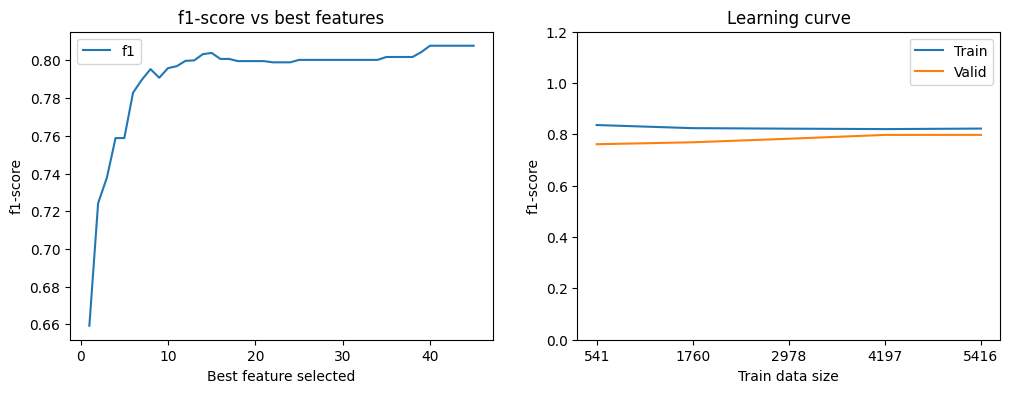

In [453]:
# let's optimize the quantity of features used
def optimize_featuresQty(estimator, X_train=X_train_sc, X_test=X_test_sc, y_train=y_train, y_test=y_test):
    """The function is designed to plot the dependencies of score-best_features_qty and learning plot

    Args:
        estimator (_type_): _description_
        X_train (DataFrame, optional): X_train subset. Defaults to X_train.
        X_test (DataFrame, optional): X_test subset. Defaults to X_test.
        y_train (Series, optional): target feature vector, train subset. Defaults to y_train.
        y_test (Series, optional): target feature vector, test subset. Defaults to y_test.
    """
    fig,ax = plt.subplots(1,2, figsize=(12,4))

    def plot_fea_qty(estimator, X_train, X_test, y_train, y_test, ax=ax[0]):
        lst = []
        for n in range(1, (X_train.shape[1]+1)):
            sel = SelectKBest(f_classif, k=n)
            sel = sel.fit(X_train, y_train)
            best_fea = sel.get_feature_names_out()
            estimator.fit(X_train[best_fea], y_train)
            y_test_pred = estimator.predict(X_test[best_fea])
            score = metrics.f1_score(y_test, y_test_pred)
            lst.append(score)
        sns.lineplot(x=range(1, (X_train.shape[1]+1)), y=lst, label='f1', ax=ax)
        ax.set_title("f1-score vs best features")
        ax.set_xlabel("Best feature selected")
        ax.set_ylabel("f1-score")
        ax.legend(loc='best')
      
    def plot_learning_curve(estimator, X_train, y_train, ax=ax[1], scoring="f1"):
        skf = model_selection.StratifiedKFold(n_splits=5)
        train_sizes, train_scores, valid_scores = model_selection.learning_curve(
            estimator=estimator,  
            X=X_train,  
            y=y_train,  
            cv=skf, 
            scoring=scoring
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        valid_scores_mean = np.mean(valid_scores, axis=1)
        ax.plot(train_sizes, train_scores_mean, label="Train")
        ax.plot(train_sizes, valid_scores_mean, label="Valid")
        ax.set_title("Learning curve")
        ax.set_xlabel("Train data size")
        ax.set_ylabel("f1-score")
        ax.xaxis.set_ticks(train_sizes)
        ax.set_ylim(0, 1.2)
        ax.legend(loc='best')

    plot_fea_qty(estimator, X_train, X_test, y_train, y_test, ax=ax[0])
    plot_learning_curve(estimator, X_train, y_train, ax=ax[1], scoring="f1")

optimize_featuresQty(estimator=tree.DecisionTreeClassifier(**gs.best_params_, random_state=42))

In [454]:
# 15 features seems to be optimal
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train_sc, y_train)
 
best_fea = selector.get_feature_names_out()
X_train_scaled = X_train_sc[best_fea]
X_test_scaled = X_test_sc[best_fea]
best_fea.tolist()

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

In [455]:
dt = tree.DecisionTreeClassifier(
    **gs.best_params_,
    random_state=42 
)

dt.fit(X_train_scaled, y_train)

y_pred_train = dt.predict(X_train_scaled)
y_pred_test = dt.predict(X_test_scaled)

print(f"TRAIN {metrics.classification_report(y_train, y_pred_train)}")
print(f"TEST {metrics.classification_report(y_test, y_pred_test)}")

TRAIN               precision    recall  f1-score   support

           0       0.85      0.84      0.84      3634
           1       0.82      0.82      0.82      3136

    accuracy                           0.83      6770
   macro avg       0.83      0.83      0.83      6770
weighted avg       0.83      0.83      0.83      6770

TEST               precision    recall  f1-score   support

           0       0.84      0.81      0.82      1790
           1       0.79      0.82      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.82      0.81      3335
weighted avg       0.82      0.81      0.82      3335



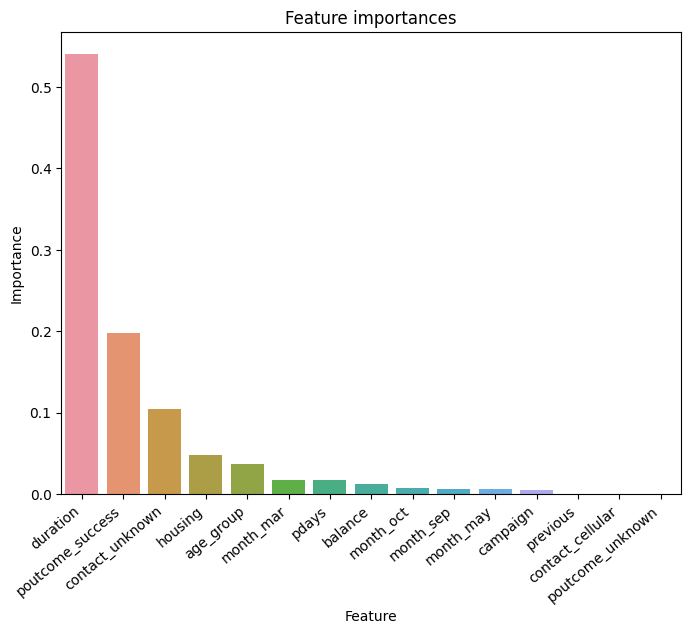

In [456]:
# plot the most important features for DTC
fea_imp = pd.DataFrame({'feature':X_train_scaled.columns, 'importance':dt.feature_importances_}).sort_values(by='importance', ascending=False)
fea_imp.sort_values(by='importance', ascending=False)

plt.subplots(figsize=(8,6))
bp_imp = sns.barplot(fea_imp, x='feature', y='importance')
bp_imp.set(xlabel='Feature', ylabel='Importance', title=f"Feature importances")
plt.xticks(rotation=40, ha='right');
#bp_imp.tick_params(axis='x',rotation=40, direction='out', pad=2, length=5, grid_alpha=0.3, which='both', color='red')

### RandomForest

In [457]:
rf= ensemble.RandomForestClassifier(
    #n_estimators=100, 
    #criterion='gini', 
    #max_depth=10, 
    #min_samples_leaf=5, 
    random_state=42 
)
#Обучаем модель 
rf.fit(X_train_scaled, y_train)

y_pred_train = rf.predict(X_train_scaled)
y_pred_test = rf.predict(X_test_scaled)

print(f"TRAIN {metrics.classification_report(y_train, y_pred_train)}")
print(f"TEST {metrics.classification_report(y_test, y_pred_test)}")


TRAIN               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

TEST               precision    recall  f1-score   support

           0       0.85      0.81      0.83      1790
           1       0.79      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



    The model is overfitted. We're supposed to sort it out

In [458]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  model.fit(X_train_scaled, y_train)
  score_tr = metrics.f1_score(y_train, model.predict(X_train_scaled))
  score_te = metrics.f1_score(y_test, model.predict(X_test_scaled))
  #score = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring="f1", n_jobs=-1).mean()
  score = score_te / (score_tr - score_te)
  return score

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

study.optimize(optuna_rf, n_trials=20)

print("Best params {}".format(study.best_params))
print("TEST. f1_score: {:.2f}".format(study.best_value))

rfc_best_params = study.best_params

[I 2023-10-31 12:30:31,728] A new study created in memory with name: RandomForestClassifier
[I 2023-10-31 12:30:32,333] Trial 0 finished with value: 22.511762636139675 and parameters: {'n_estimators': 138, 'max_depth': 23, 'min_samples_leaf': 8}. Best is trial 0 with value: 22.511762636139675.
[I 2023-10-31 12:30:33,088] Trial 1 finished with value: 18.245515833745593 and parameters: {'n_estimators': 155, 'max_depth': 19, 'min_samples_leaf': 6}. Best is trial 0 with value: 22.511762636139675.
[I 2023-10-31 12:30:33,726] Trial 2 finished with value: 23.793498988898104 and parameters: {'n_estimators': 146, 'max_depth': 23, 'min_samples_leaf': 9}. Best is trial 2 with value: 23.793498988898104.
[I 2023-10-31 12:30:34,272] Trial 3 finished with value: 23.85383231632049 and parameters: {'n_estimators': 137, 'max_depth': 28, 'min_samples_leaf': 10}. Best is trial 3 with value: 23.85383231632049.
[I 2023-10-31 12:30:35,056] Trial 4 finished with value: 7.9522639067320995 and parameters: {'n_e

Best params {'n_estimators': 199, 'max_depth': 10, 'min_samples_leaf': 9}
TEST. f1_score: 28.05


In [459]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)

y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

print(f"TRAIN {metrics.classification_report(y_train, y_pred_train)}")
print(f"TEST {metrics.classification_report(y_test, y_pred_test)}")


TRAIN               precision    recall  f1-score   support

           0       0.87      0.85      0.86      3634
           1       0.83      0.85      0.84      3136

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770

TEST               precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### GradientBoosting

In [460]:
gb = GradientBoostingClassifier(
        learning_rate = 0.05,
        n_estimators = 300,
        min_samples_leaf = 5,
        max_depth = 5,
        random_state = 42
)

gb.fit(X_train_scaled, y_train)

y_pred_train = gb.predict(X_train_scaled)
y_pred_test = gb.predict(X_test_scaled)

print(f"TRAIN {metrics.classification_report(y_train, y_pred_train)}")
print(f"TEST {metrics.classification_report(y_test, y_pred_test)}")

TRAIN               precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

TEST               precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.82      0.83      0.82      3335
weighted avg       0.83      0.83      0.83      3335



In [461]:
# optimize hyperparameters with Optuna
def optuna_rf(trial):
  learning_rate = trial.suggest_float('learning_rate',0.01, 1)#, step=0.05)
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 1, 8, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8, 1)

  model = ensemble.GradientBoostingClassifier(n_estimators=n_estimators,
                                          learning_rate=learning_rate,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  model.fit(X_train_scaled, y_train)
  #score_tr = metrics.f1_score(y_train, model.predict(X_train_scaled))
  score = metrics.f1_score(y_test, model.predict(X_test_scaled))
  #score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
  #score = score_te / (score_tr - score_te)
  return score

study = optuna.create_study(study_name="GBClassifier", direction="maximize")

study.optimize(optuna_rf, n_trials=20)

print("Best params: {}".format(study.best_params))
print("TEST f1_score: {:.2f}".format(study.best_value))

gbc_best_params = study.best_params

[I 2023-10-31 12:30:48,231] A new study created in memory with name: GBClassifier
[I 2023-10-31 12:30:49,471] Trial 0 finished with value: 0.7789541225537376 and parameters: {'learning_rate': 0.5397051430129689, 'n_estimators': 126, 'max_depth': 6, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7789541225537376.
[I 2023-10-31 12:30:49,857] Trial 1 finished with value: 0.8083036003892313 and parameters: {'learning_rate': 0.5728328871379779, 'n_estimators': 108, 'max_depth': 2, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8083036003892313.
[I 2023-10-31 12:30:52,106] Trial 2 finished with value: 0.7851899138206193 and parameters: {'learning_rate': 0.6902044062741146, 'n_estimators': 163, 'max_depth': 8, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8083036003892313.
[I 2023-10-31 12:30:54,613] Trial 3 finished with value: 0.7789137380191692 and parameters: {'learning_rate': 0.651144825552927, 'n_estimators': 191, 'max_depth': 8, 'min_samples_leaf': 8}. Best is tri

Best params: {'learning_rate': 0.04030717653007107, 'n_estimators': 200, 'max_depth': 3, 'min_samples_leaf': 1}
TEST f1_score: 0.82


In [462]:
model = ensemble.GradientBoostingClassifier(**gbc_best_params,random_state=42)
model.fit(X_train_scaled, y_train)

y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

print(f"TRAIN {metrics.classification_report(y_train, y_pred_train)}")
print(f"TEST {metrics.classification_report(y_test, y_pred_test)}")

TRAIN               precision    recall  f1-score   support

           0       0.87      0.85      0.86      3634
           1       0.83      0.85      0.84      3136

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770

TEST               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1790
           1       0.81      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Stacking

In [463]:
# let's stack 3 previous models
estimators = [
    ('dr',tree.DecisionTreeClassifier(
        **dt_best_params,
        random_state=42)),
    ('rf', ensemble.RandomForestClassifier(
        **rfc_best_params, 
        random_state=42)),
    ('gb', GradientBoostingClassifier(
        **gbc_best_params,
        random_state= 42))    
]

sc = StackingClassifier(
    estimators=estimators,
    #final_estimator=RandomForestRegressor(n_estimators=10, random_state=42)
    final_estimator=linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
)

sc.fit(X_train_scaled, y_train)

y_pred_train = sc.predict(X_train_scaled)
y_pred_test = sc.predict(X_test_scaled)

print(f"TRAIN {metrics.classification_report(y_train, y_pred_train)}")
print(f"TEST {metrics.classification_report(y_test, y_pred_test)}")

TRAIN               precision    recall  f1-score   support

           0       0.87      0.85      0.86      3634
           1       0.83      0.85      0.84      3136

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770

TEST               precision    recall  f1-score   support

           0       0.84      0.83      0.84      1790
           1       0.81      0.82      0.81      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Best threshold = 0.29, F1-Score = 0.83


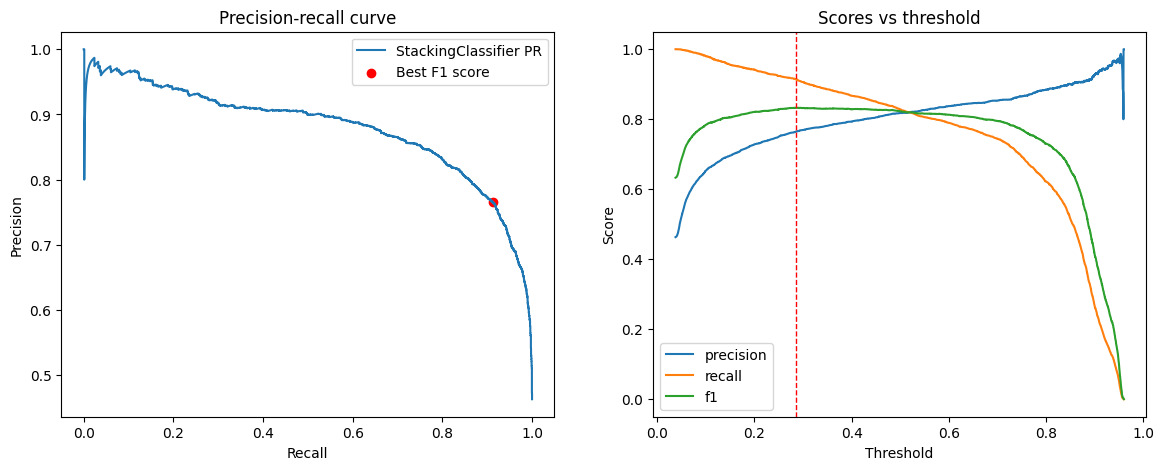

In [464]:
# Let's optimize the threshold to get the best f1-score

y_cv_proba_pred = model_selection.cross_val_predict(sc, X_train_scaled, y_train, cv=5, method='predict_proba')
y_cv_proba_pred = y_cv_proba_pred[:,1]

precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

f1_scores = (2 * precision * recall) / (precision + recall)
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))


fig, ax = plt.subplots(1,2,figsize=(14, 5)) 
ax[0].plot(recall, precision, label='StackingClassifier PR')
ax[0].scatter(recall[idx], precision[idx], marker='o', color='red', label='Best F1 score')
ax[1].plot(thresholds, precision[:-1], label='precision')
ax[1].plot(thresholds, recall[:-1], label='recall')
ax[1].plot(thresholds, f1_scores[:-1], label='f1')
ax[1].axvline(thresholds[idx], color='r', lw=1, ls='--')

ax[0].set_title('Precision-recall curve')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].legend()
ax[1].set_title('Scores vs threshold')
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Score')
ax[1].legend();

In [466]:
threshold_opt = 0.29

y_test_pred_proba = sc.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_pred_proba > threshold_opt).astype('int')

print(f"TEST {metrics.classification_report(y_test, y_test_pred)}")

TEST               precision    recall  f1-score   support

           0       0.91      0.76      0.83      1790
           1       0.76      0.91      0.83      1545

    accuracy                           0.83      3335
   macro avg       0.84      0.83      0.83      3335
weighted avg       0.84      0.83      0.83      3335



    The best scores we managed to get for the test subset: f1-score=0.83, accuracy=0.83